In [1]:
! pip install pyDOE
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import torch.optim as optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

torch.manual_seed(1234)
np.random.seed(1234)


if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1234)

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(device)

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=1d2e01584750c385a794b952a7c2d627b71a878eb05a77366a8e12631501c005
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE
True
1
cuda


(20459, 2)


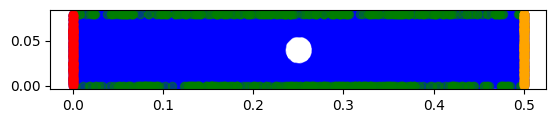

In [6]:
y_min = 0
x_min = 0
x_max = 0.5
y_max = 0.08

N_b = 1500
N_i = 2000
N_c = 20000
t_min = 0
t_max = 1
rho = 1
mu = 0.01
Re = 200

ub = np.array([x_max, y_max])
lb = np.array([x_min, y_min])

p_out1 = 0
u_top1 = 0
u_bottom1 = 0
v_top1 = 0
v_bottom1 = 0
u_circle1 = 0
v_circle1 = 0
u_i = 0
v_i = 0
u_ent = 1
v_ent = 0




N_c = 20000
N_b = 200
N_w = 250
N_s = 100
N_r = 100




def getData():
  # inlet, v=0 & inlet velocity
  inlet_x = np.zeros((N_b, 1))
  inlet_y = np.random.uniform(y_min, y_max, (N_b, 1))
  inlet_u = np.ones((N_b, 1))
  inlet_v = np.zeros((N_b, 1))
  inlet_xy = np.concatenate([inlet_x, inlet_y], axis=1)
  inlet_uv = np.concatenate([inlet_u, inlet_v], axis=1)

  # outlet, p=0
  xy_outlet = np.random.uniform([x_max, y_min], [x_max, y_max], (N_b, 2))

  # wall, u=v=0
  upwall_xy = np.random.uniform([x_min, y_max], [x_max, y_max], (N_w, 2))
  dnwall_xy = np.random.uniform([x_min, y_min], [x_max, y_min], (N_w, 2))
  upwall_uv = np.zeros((N_w, 2))
  dnwall_uv = np.zeros((N_w, 2))

  #circle
  circle_center = [(x_max + x_min) / 2 , (y_max + y_min) / 2]
  r = 0.02
  xc, yc = circle_center
  theta = np.linspace(0.0, 2 * np.pi, N_s)
  cyl_x = (r * np.cos(theta) + xc).reshape(-1, 1)
  cyl_y = (r * np.sin(theta) + yc).reshape(-1, 1)
  cyl_xy = np.concatenate([cyl_x, cyl_y], axis=1)
  cyl_uv = np.zeros((N_s, 2))
 # all boundary except outlet
  xy_bnd = np.concatenate([inlet_xy, upwall_xy, dnwall_xy, cyl_xy], axis=0)
  uv_bnd = np.concatenate([inlet_uv, upwall_uv, dnwall_uv, cyl_uv], axis=0)

   # Collocation
  xy_col = lb + (ub - lb) * lhs(2, N_c)

  # refine points around cylider
  refine_ub = np.array([xc + 2 * r, yc + 2 * r])
  refine_lb = np.array([xc - 2 * r, yc - 2 * r])
  xy_col_refine = refine_lb + (refine_ub - refine_lb) * lhs(2, N_r)
  xy_col = np.concatenate([xy_col, xy_col_refine], axis=0)

  # remove collocation points inside the cylinder
  dst_from_cyl = np.sqrt((xy_col[:, 0] - xc) **2 + (xy_col[:, 1] - yc)** 2)
  xy_col = xy_col[dst_from_cyl > r].reshape(-1, 2)

  # concatenate all xy for collocation
  xy_col = np.concatenate((xy_col, xy_bnd, xy_outlet), axis=0)


  print(xy_col.shape)
  fig, ax = plt.subplots()
  ax.set_aspect('equal')
  plt.scatter(xy_col[:,0:1], xy_col[:,1:2], marker='o', alpha=0.4 ,color='blue')
  plt.scatter(upwall_xy[:,0:1], upwall_xy[:,1:2], marker='o', alpha=0.5 , color='green')
  plt.scatter(dnwall_xy[:,0:1], dnwall_xy[:,1:2], marker='o', alpha=0.5 , color='green')
  plt.scatter(xy_outlet[:, 0:1], xy_outlet[:, 1:2], marker='o', alpha=0.5, color='orange')
  plt.scatter(inlet_xy[:, 0:1], inlet_xy[:, 1:2], marker='o', alpha=0.5, color='red')
  plt.show()

  # convert to tensor
  xy_bnd = torch.tensor(xy_bnd, dtype=torch.float32).to(device)
  uv_bnd = torch.tensor(uv_bnd, dtype=torch.float32).to(device)
  xy_outlet = torch.tensor(xy_outlet, dtype=torch.float32).to(device)
  xy_col = torch.tensor(xy_col, dtype=torch.float32).to(device)

  return xy_col, xy_bnd, uv_bnd, xy_outlet

xy_col, xy_bnd, uv_bnd, xy_outlet = getData()

 It: 100 Loss: 4.88004e+00 BC: 4.686e+00 outlet: 7.188e-04 pde: 1.929e-01
 It: 200 Loss: 2.70804e+00 BC: 2.518e+00 outlet: 2.590e-04 pde: 1.894e-01
 It: 300 Loss: 2.41849e+00 BC: 2.290e+00 outlet: 3.126e-05 pde: 1.282e-01
 It: 400 Loss: 2.38649e+00 BC: 2.258e+00 outlet: 5.501e-06 pde: 1.288e-01
 It: 500 Loss: 2.36665e+00 BC: 2.238e+00 outlet: 2.900e-06 pde: 1.288e-01
 It: 600 Loss: 2.34121e+00 BC: 2.215e+00 outlet: 2.194e-07 pde: 1.261e-01
 It: 700 Loss: 2.28124e+00 BC: 2.166e+00 outlet: 1.711e-06 pde: 1.157e-01
 It: 800 Loss: 2.10642e+00 BC: 1.986e+00 outlet: 3.100e-05 pde: 1.205e-01
 It: 900 Loss: 1.75740e+00 BC: 1.622e+00 outlet: 1.046e-04 pde: 1.354e-01
 It: 1000 Loss: 1.47360e+00 BC: 1.289e+00 outlet: 6.319e-05 pde: 1.844e-01
 It: 1100 Loss: 1.19662e+00 BC: 1.085e+00 outlet: 2.153e-05 pde: 1.121e-01
 It: 1200 Loss: 1.04834e+00 BC: 9.693e-01 outlet: 5.092e-05 pde: 7.903e-02
 It: 1300 Loss: 9.86672e-01 BC: 9.197e-01 outlet: 8.076e-05 pde: 6.690e-02
 It: 1400 Loss: 9.68922e-01 BC: 9.

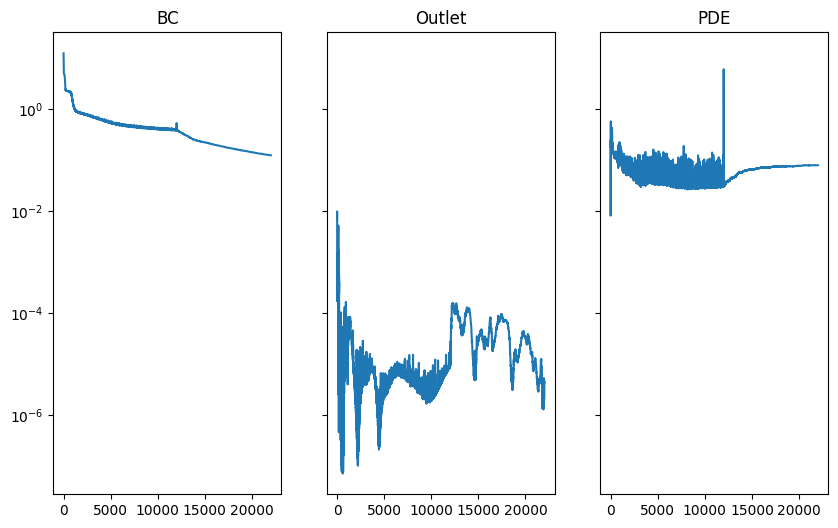

In [7]:
def plotLoss(losses_dict, path, info=["I.C.", "B.C.", "P.D.E."]):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 6))
    axes[0].set_yscale("log")
    for i, j in zip(range(3), info):
        axes[i].plot(losses_dict[j.lower()])
        axes[i].set_title(j)
    plt.show()
    fig.savefig(path)

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

class layer(nn.Module):

    def __init__(self, n_in, n_out, activation):
        super().__init__()
        self.layer = nn.Linear(n_in, n_out)
        self.activation = activation

    def forward(self, x):
        x = self.layer(x)
        if self.activation:
            x = self.activation(x)
        return x

class DNN(nn.Module):

    def __init__(self, dim_in, dim_out, n_layer, n_node, ub, lb, activation=nn.Tanh()):
        super().__init__()
        self.net = nn.ModuleList()
        self.net.append(layer(dim_in, n_node, activation))
        for _ in range(n_layer):
            self.net.append(layer(n_node, n_node, activation))
        self.net.append(layer(n_node, dim_out, activation=None))
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        self.net.apply(weights_init)

    def forward(self, x):
        # x = (x - self.lb) / (self.ub - self.lb)
        out = x
        for layer in self.net:
            out = layer(out)
        return out

class PINN:

    rho = 1
    mu = 0.02
    def __init__(self) -> None:
        self.net = DNN(dim_in=2, dim_out=6, n_layer=4, n_node=50, ub=ub, lb=lb).to(
            device
        )

        self.lbfgs = torch.optim.LBFGS(
            self.net.parameters(),
            lr=1.0,
            max_iter=10000,
            max_eval=10000,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            history_size=50,
            line_search_fn="strong_wolfe",
        )

        self.adam = torch.optim.Adam(self.net.parameters(), lr=5e-4)
        self.losses = {"bc": [], "outlet": [], "pde": []}
        self.iter = 0

    def predict(self, X):
        out = self.net(X)

        u = out[:, 0:1]
        v = out[:, 1:2]
        p = out[:, 2:3]

        sig_xx = out[:, 3:4]
        sig_xy = out[:, 4:5]
        sig_yy = out[:, 5:6]

        return u, v, p, sig_xx, sig_xy, sig_yy

    def bc_loss(self, X):
        u, v = self.predict(X)[0:2]

        mse_bc = torch.mean(torch.square(u - uv_bnd[:, 0:1])) + torch.mean(
            torch.square(v - uv_bnd[:, 1:2])
        )

        return mse_bc

    def outlet_loss(self, X):
        out = self.net(X)

        p = out[:, 2:3]

        mse_outlet = torch.mean(torch.square(p))

        return mse_outlet

    def pde_loss(self, X):
        X = X.clone()
        X.requires_grad = True

        u, v, p, sig_11, sig_12, sig_22 = self.predict(X)

        u_out = grad(u.sum(), X, create_graph=True)[0]
        v_out = grad(v.sum(), X, create_graph=True)[0]

        sig_11_out = grad(sig_11.sum(), X, create_graph=True)[0]
        sig_12_out = grad(sig_12.sum(), X, create_graph=True)[0]
        sig_22_out = grad(sig_22.sum(), X, create_graph=True)[0]

        u_x = u_out[:, 0:1]
        u_y = u_out[:, 1:2]
        v_x = v_out[:, 0:1]
        v_y = v_out[:, 1:2]
        v_t = u_out[:, 2:3]

        sig_11_x = sig_11_out[:, 0:1]
        sig_12_x = sig_12_out[:, 0:1]
        sig_12_y = sig_12_out[:, 1:2]
        sig_22_y = sig_22_out[:, 1:2]

        f0 = u_x + v_y

        f1 = (u*u_x + v*u_y) - sig_11_x - sig_12_y
        f2 = (u*v_x + v*v_y) - sig_12_x - sig_22_y

        f3 = -p + (2/Re) * u_x - sig_11
        f4 = -p + (2/Re) * v_y - sig_22
        f5 = (1/Re) * (u_y + v_x) - sig_12

        mse_f0 = torch.mean(torch.square(f0))
        mse_f1 = torch.mean(torch.square(f1))
        mse_f2 = torch.mean(torch.square(f2))
        mse_f3 = torch.mean(torch.square(f3))
        mse_f4 = torch.mean(torch.square(f4))
        mse_f5 = torch.mean(torch.square(f5))

        mse_pde = mse_f0 + mse_f1 + mse_f2 + mse_f3 + mse_f4 + mse_f5

        return mse_pde

    def closure(self):

        self.lbfgs.zero_grad()
        self.adam.zero_grad()

        mse_bc = self.bc_loss(xy_bnd) * 50
        mse_outlet = self.outlet_loss(xy_outlet)
        mse_pde = self.pde_loss(xy_col)

        loss = mse_bc + mse_outlet + mse_pde

        loss.backward()

        self.losses["bc"].append(mse_bc.detach().cpu().item())
        self.losses["outlet"].append(mse_outlet.detach().cpu().item())
        self.losses["pde"].append(mse_pde.detach().cpu().item())

        self.iter += 1

        print(
            f"\r It: {self.iter} Loss: {loss.item():.5e} BC: {mse_bc.item():.3e} outlet: {mse_outlet.item():.3e} pde: {mse_pde.item():.3e}",
            end="",
        )

        if self.iter % 100 == 0:
            print("")

        return loss

if __name__ == "__main__":

    pinn = PINN()
    start_time = time.time()

    for i in range(12000):
        pinn.closure()
        pinn.adam.step()
    pinn.lbfgs.step(pinn.closure)

    print("--- %s seconds ---" % (time.time() - start_time))
    print(f'-- {(time.time() - start_time)/60} mins --')
    torch.save(pinn.net.state_dict(), "/content/Param.pt")
    plotLoss(pinn.losses, "/content/LossCurve.png", ["BC", "Outlet", "PDE"])


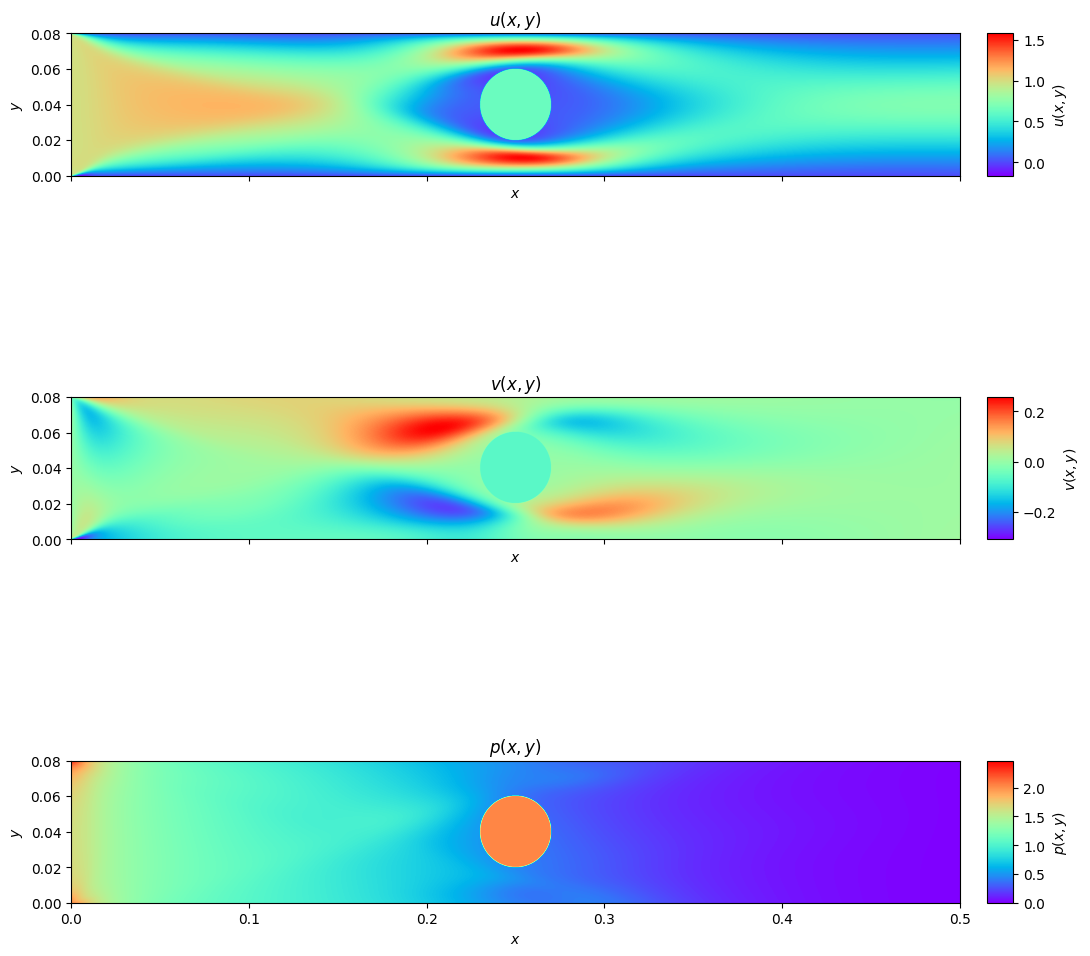

In [8]:
pinn = PINN()

pinn.net.load_state_dict(torch.load("/content/Param.pt"))

step_size = 0.0001

x = np.arange(x_min, x_max, step_size)
y = np.arange(y_min, y_max, step_size)

X, Y = np.meshgrid(x, y)

x = X.reshape(-1, 1)
y = Y.reshape(-1, 1)

xyn = np.concatenate([x, y], axis=1)
xy = []
for x in xyn:
    if (((x[0] - 0.25)**2 + (x[1] - 0.04)**2)**(0.5)) < 0.02:
        xy.append([0, 0])
    else:
        xy.append([x[0], x[1]])

xy = np.array(xy)

xy = torch.tensor(xy, dtype=torch.float32).to(device)

with torch.no_grad():
    u, v, p, sig_xx, sig_xy, sig_yy = pinn.predict(xy)
    u = u.cpu().numpy()
    u = u.reshape(Y.shape)

    v = v.cpu().numpy()
    v = v.reshape(Y.shape)

    p = p.cpu().numpy()
    p = p.reshape(Y.shape)

fig, axes = plt.subplots(3, 1, figsize=(11, 12), sharex=True)
data = (u, v, p)
labels = ["$u(x,y)$", "$v(x,y)$", "$p(x,y)$"]
for i in range(3):
    ax = axes[i]
    im = ax.imshow(
        data[i], cmap="rainbow", extent=[x_min, x_max, y_min, y_max], origin="lower"
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad="3%")
    fig.colorbar(im, cax=cax, label=labels[i])
    ax.set_title(labels[i])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect("equal")

fig.tight_layout()

fig.savefig("/content/Sol.png", dpi=500)